### 1 import cleaning data
- import cleaned data

### 2 Feature Engineering
- Adding Humidity in weather data
- Merging train data and weather data
- Drop strong co-correlate feature
- Merging test data and weather data
- Get dummy for Category Cols
- Split data to X,y Train and Val
- Scale data by using StandardScaler
- Balance Target variable by using SMOTE

### 3 Modeling ( 1st round )
- Logistic Regression
- Random Forest Classifier
- KNeighbors Classifier
- Adaboost
- BernoulliNB

### 4 Evaluate Model (1st round)
- Adaboost has the lowest False Negative but the kaggle score is low when compare with LR

### 5 Time Series Feature Engineering
- adding Lag features in weather dataframe
- Drop strong co-correlate feature
- Get dummy for Category Cols


### 6 Feature Selection
- Split data to X,y Train and Val
- Scale data by using StandardScaler
- Balance Target variable by using SMOTE

### 7 Modeling ( 2st round )
- Logistic Regression
- Random Forest Classifier
- KNeighbors Classifier
- Adaboost
- BernoulliNB

### 8 Evaluate Model (2nd round)
- LR has the lowest False Negative and the kaggle score is the best when compare with others

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier,BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve
# modeling imports
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import svm
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score,confusion_matrix, plot_roc_curve

# 1. Import Data

In [2]:
#test = pd.read_csv('cleaned/new/clean_test.csv')
test = pd.read_csv('data/test_with_mosnum.csv')
train = pd.read_csv('data/clean_train.csv')
weather= pd.read_csv('data/clean_weather.csv')

# Import spray file
spray = pd.read_csv('data/clean_spray.csv')

In [3]:
#check null in train data
train.isnull().sum()

date               0
species            0
trap               0
latitude           0
longitude          0
addressaccuracy    0
nummosquitos       0
wnvpresent         0
day                0
month              0
year               0
week               0
dtype: int64

In [4]:
#check null in test data
test.isnull().sum()

id                 0
date               0
species            0
trap               0
latitude           0
longitude          0
addressaccuracy    0
day                0
month              0
year               0
week               0
nummosquitos       0
dtype: int64

In [5]:
#check null in weather data
weather.isnull().sum()

station         0
date            0
tmax            0
tmin            0
tavg            0
depart          0
dewpoint        0
wetbulb         0
heat            0
cool            0
sunrise         0
sunset          0
codesum         0
snowfall        0
preciptotal     0
stnpressure     0
sealevel        0
resultspeed     0
resultdir       0
avgspeed        0
day             0
month           0
year            0
week            0
hour_sunrise    0
min_sunrise     0
hour_sunset     0
min_sunset      0
dtype: int64

# 2. Feature Engineering

### Adding Humidity in weather data

We would like to create new feature:
 - **Humidity** - as a hypothesis which will effect the present of WNV so we will calculate the humidity as new feature to see is it effect present of WNV or not


In [6]:
# Create function to calculate relative humidity
def cal_rh(temperature, dewpoint):
    Tavg_C = ((temperature - 32) * 5 / 9)
    DewPoint_C = ((dewpoint - 32) * 5 / 9)
    VapPress_Sat = np.exp((17.625 * Tavg_C) / (Tavg_C + 243.04))
    VapPress_Act = np.exp((17.625 * DewPoint_C) / (DewPoint_C + 243.04))
    R_Humidity = (VapPress_Act / VapPress_Sat) * 100
    
    return R_Humidity

In [7]:
#add Humidity in weather data
weather['r_humidity'] = round(cal_rh(weather['tavg'], weather['dewpoint']),2)

In [8]:
#create new dataframe with the average of columns for the two weather stations
weather_both = pd.DataFrame()
station_1 = weather[weather['station'] == 1].reset_index()
station_2 = weather[weather['station'] == 2].reset_index()
weather_both['date'] = station_1['date']

def avg_station(df):
    for col in df:
        weather_both[col] = (station_1[col] + station_2[col])*.5
avg_station(weather.drop(['date','station'],axis=1))
weather = weather_both

In [9]:
weather.shape

(1472, 28)

### Merging train data and weather data
- we will merge 2 dataframe train and weather before make it into a single dataframe call final_df

In [10]:
final_df = pd.merge(train, weather.drop(columns = ['day','month','year']), on = 'date', how = 'left')

In [11]:
final_df.columns

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'week_x', 'tmax',
       'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'sunrise', 'sunset', 'codesum', 'snowfall', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       'week_y', 'hour_sunrise', 'min_sunrise', 'hour_sunset', 'min_sunset',
       'r_humidity'],
      dtype='object')

### Drop strong co-correlate feature

- We drop tmax / tmin becuase using only tavg to decrease redundant data
- We drop wetbulb because have a strong correlate with dewpoint (to decrease number of feature). 
- We drop stnpressure because have a strong correlate with sealevel (to decrease number of feature).
- We drop resultspeed because have a strong correlate with averagespeed (to decrease number of feature).

In [12]:
#creat function for scatter plot
def scatter_plot(dataframe, x, y):
    plt.figure(figsize = (12,8))
    sns.scatterplot(x = x, y=y, data = dataframe)
    plt.title(f'{x} vs {y}');

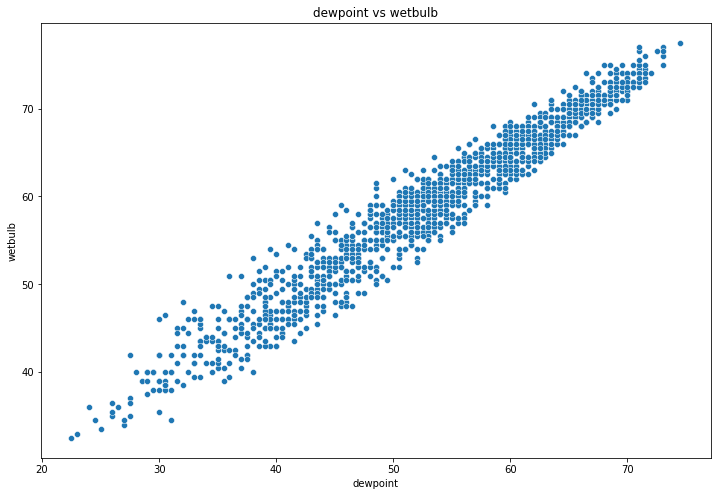

In [13]:
# show dewpoint highly correlate with wetbulb so we can drop wetbulb out of the predictor list
scatter_plot(weather, 'dewpoint','wetbulb')

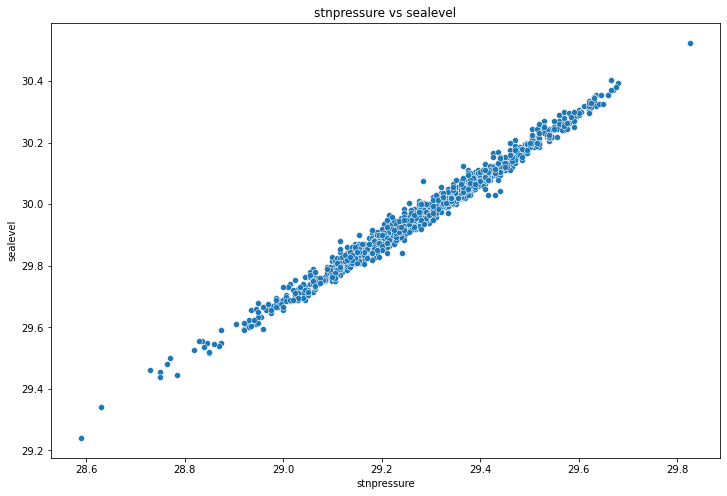

In [14]:
# show sealevel highly correlate with stnpressure so we can drop stnpressure out of the predictor list
scatter_plot(weather, 'stnpressure','sealevel')

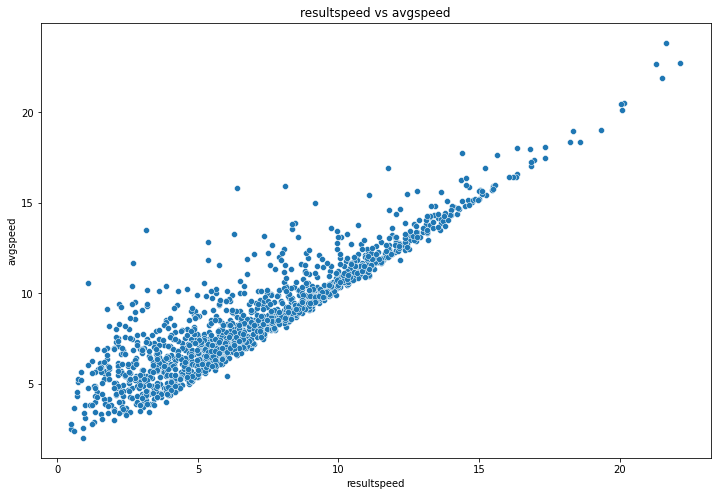

In [15]:
# show avgspeed highly correlate with resultspeed so we can drop resultspeed out of the predictor list
scatter_plot(weather, 'resultspeed','avgspeed')

### Nummosquitos

In [16]:
def line_plot(dataframe, x, y, marker = None,ci = False, hue = None, title = None, show_peak_val = None):
    plt.figure(figsize = (18,12))
    sns.lineplot(x = x, y = y, data = dataframe, marker = marker, ci = ci, hue = hue, markersize = 10)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.xticks(rotation = 45)
    
    # Show peak value
    if show_peak_val == None:
        pass
    else:
        max_x = dataframe.sort_values(by= y, ascending=False).index[0]
        max_y = dataframe.sort_values(by= y, ascending=False)[y][0]
        plt.text(x=max_x, y=max_y, s="(" + str(max_y) + ")", alpha=0.7, color='purple', fontsize = "17", fontweight="bold")
    
    plt.xlabel(f'{x}', fontsize = 20)
    plt.ylabel(f'{y}', fontsize = 20)
    if title == None:
        plt.title(f'Total {y} count by {x}', fontsize = 30)
    else:
        plt.title(title, fontsize = 30);

In [17]:
# Create new dataframe by copying train data
mosquito_df = train.copy()
mosquito_df['date'] = pd.to_datetime(mosquito_df['date'])
# Create column year month
mosquito_df['yearmonth'] = mosquito_df['date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

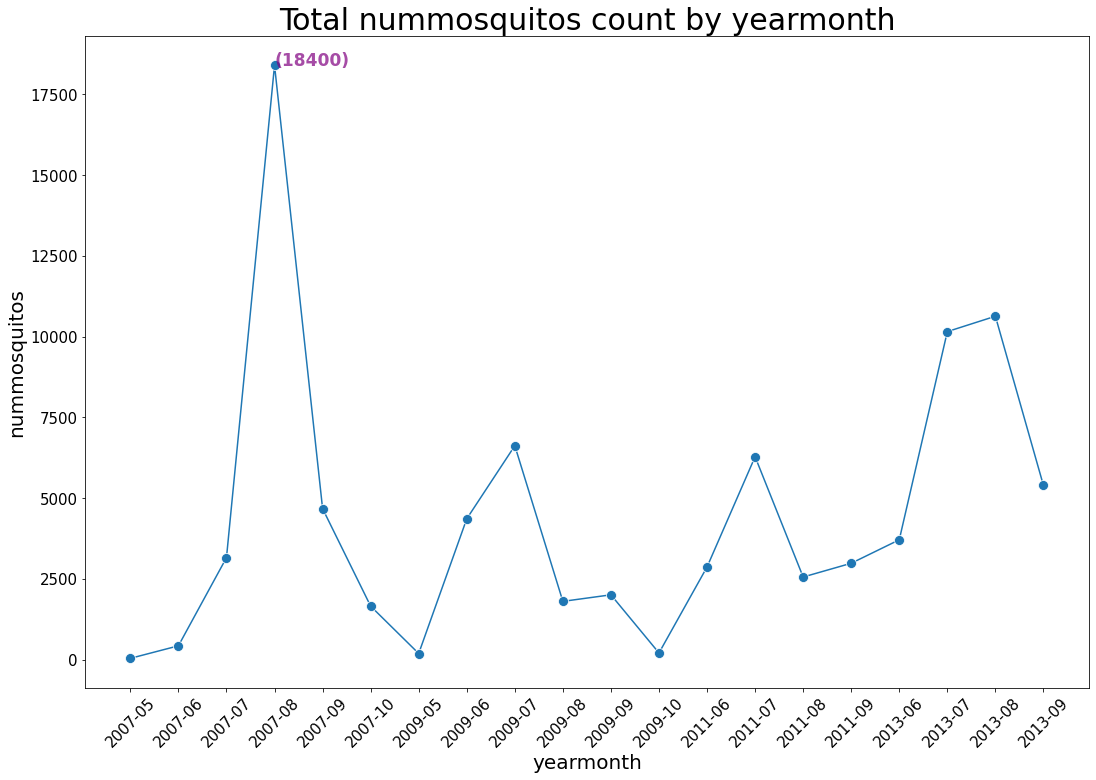

In [18]:
line_plot(mosquito_df.groupby('yearmonth').sum(), x = 'yearmonth', y = 'nummosquitos', marker = 'o', show_peak_val = 'Yes')

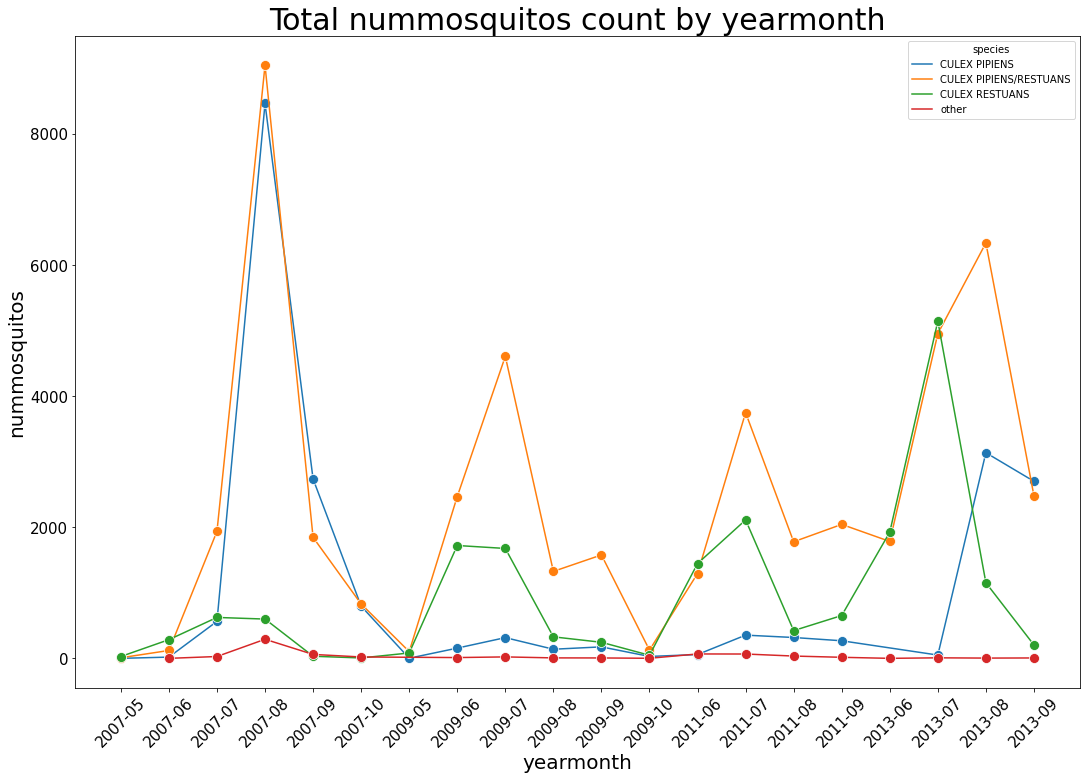

In [19]:
line_plot(mosquito_df.groupby(['yearmonth','species']).sum(), x = 'yearmonth', y = 'nummosquitos', marker = 'o', hue = 'species')

## Spray Data

In [20]:
spray['date'] = pd.to_datetime(spray['date'])

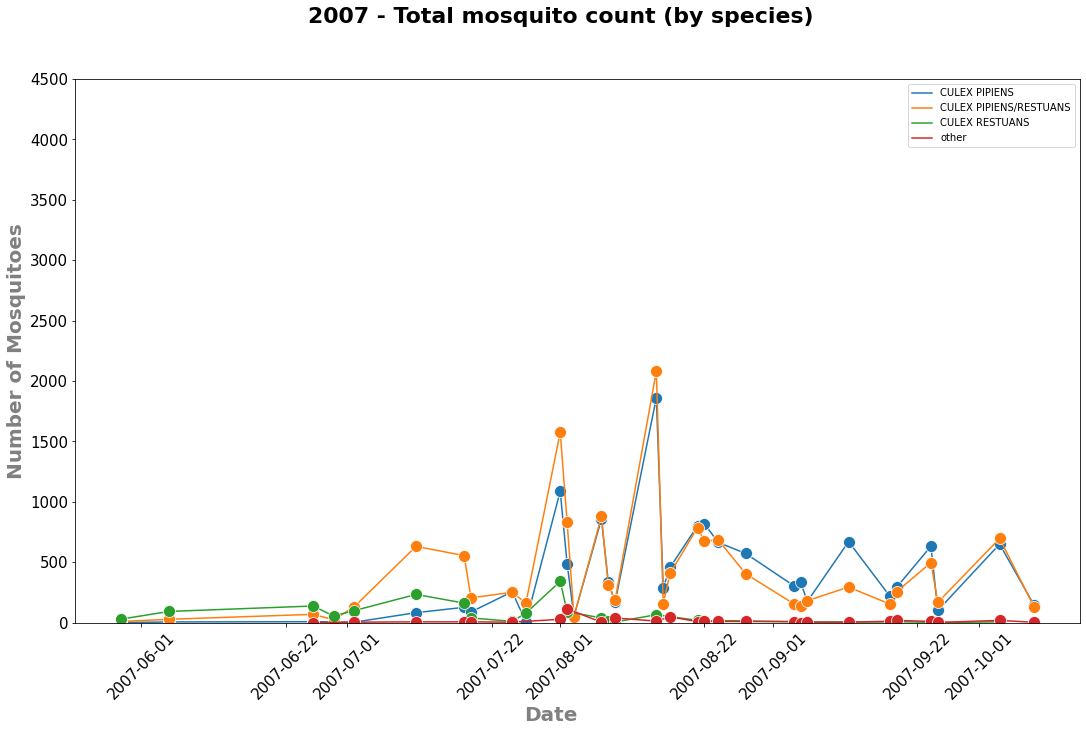

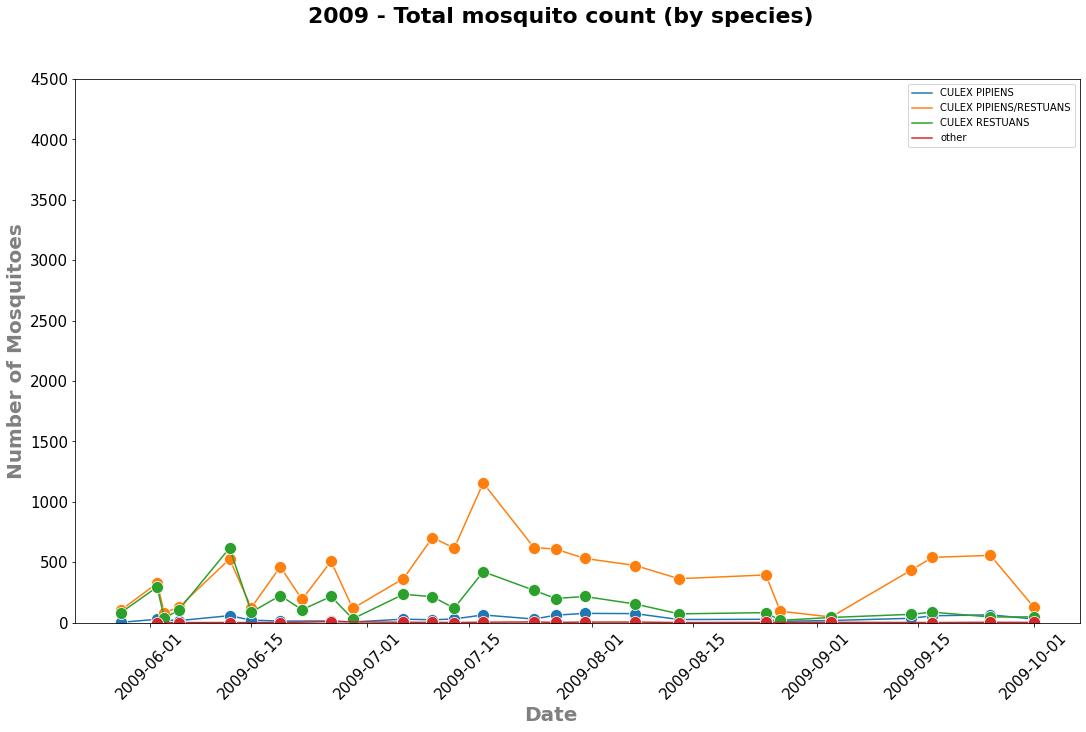

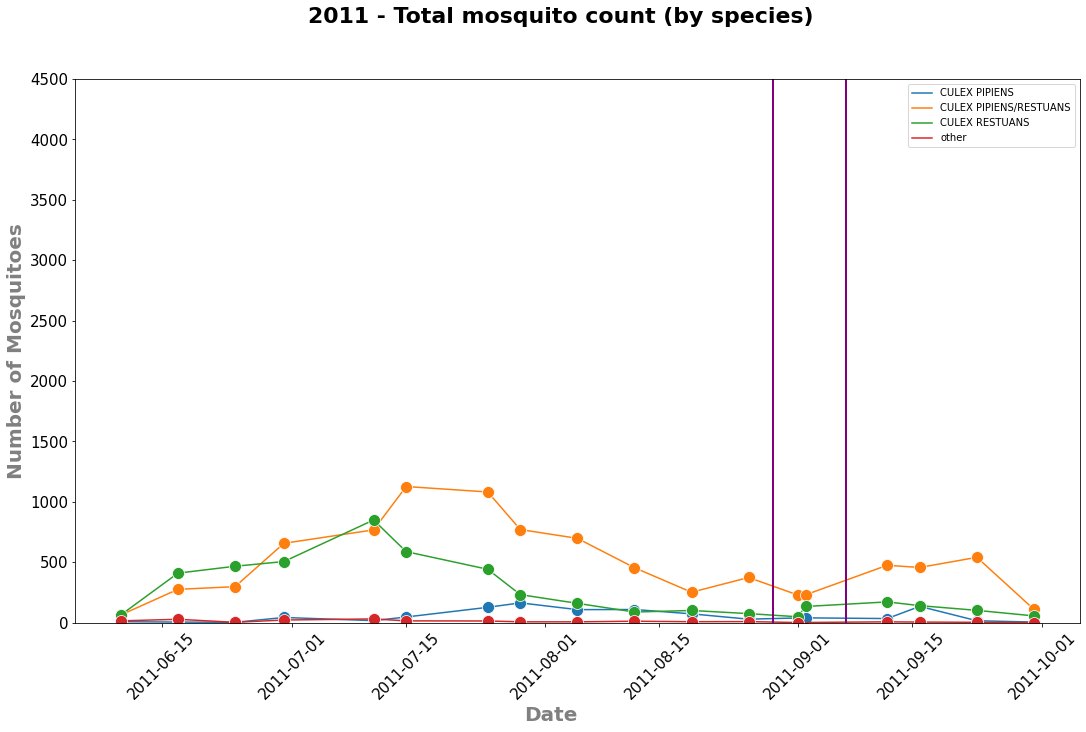

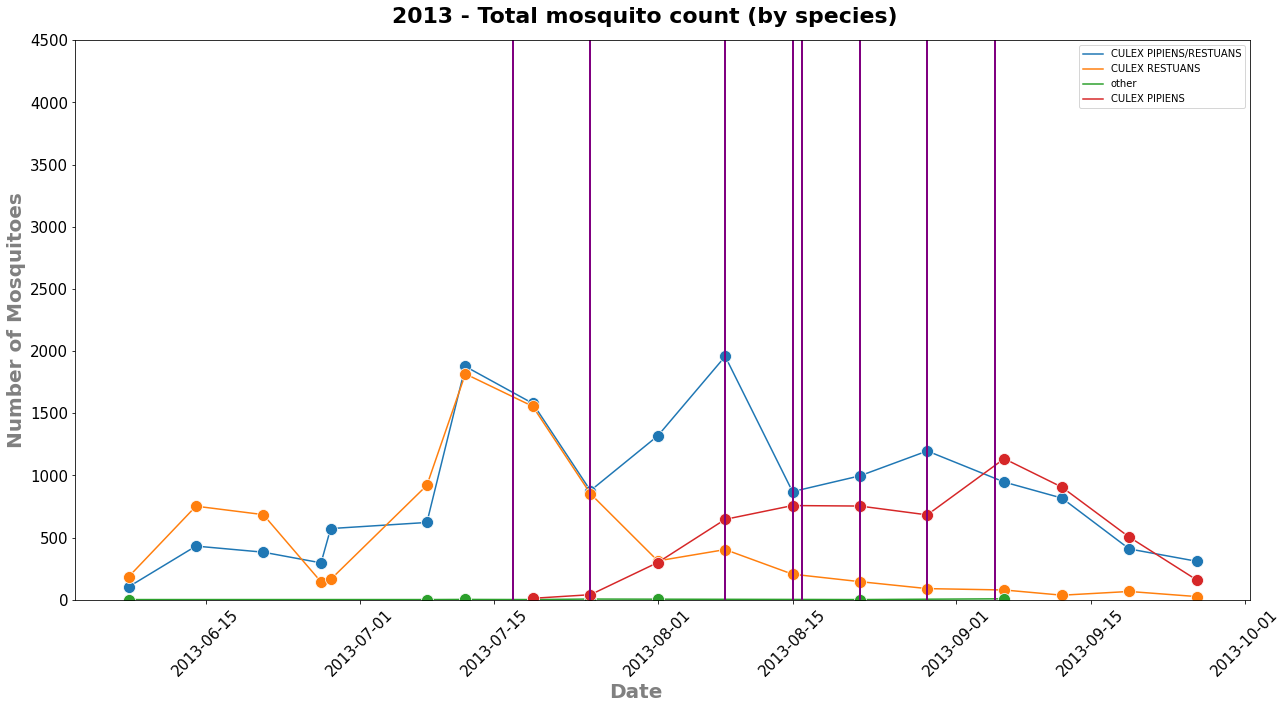

In [21]:
for yr in [y for y in mosquito_df['date'].apply(lambda x: x.year).unique()]:

    # creating a temporary df to show only records for a particular year, grouped by date and species
    temp_df = mosquito_df[mosquito_df["year"] == yr].groupby(["date", "species"]).sum()

    # since temp_df now is a multi-index df, we need to iterate through the index 
    # to pass `Date` and `Species` to the plot  function
    date_index = [keys for keys, values in temp_df.index]
    hue_index = [values for keys, values in temp_df.index]
    
    plt.figure(figsize=(18,10))

    sns.lineplot(x = date_index, y = "nummosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index)

    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    plt.ylim(0, 4500)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(rotation=45)
    
    for sp_date in spray['date']:
        if yr == sp_date.year:
            plt.axvline(sp_date, label="spray", color='purple')
        else:
            pass
    
    title = f"{yr} - Total mosquito count (by species)"
    plt.suptitle(title, fontweight='bold', fontsize='22', horizontalalignment='center')

plt.tight_layout()

From the graph, the line represents the number of mosquitoes in each month between 2007 to 2013 and the purple vertical line represents the spray date. We can see that after spraying, number of mosquitos sometimes increase sometimes decrease. So, we think that the spray will not significantly affect.

In [22]:
#final_df.drop(columns = ['date','addressaccuracy','tmax','tmin','wetbulb','stnpressure','resultspeed','trap'], inplace = True)
final_df.drop(columns = ['date','addressaccuracy','tmax','tmin','wetbulb','stnpressure','resultspeed','trap'], inplace = True)

In [23]:
final_df.shape

(8461, 28)

### Merging test data and weather data

In [24]:
final_test = pd.merge(test, weather.drop(columns = ['day','month','year']), on = 'date', how = 'left')

In [25]:
final_test.shape

(116293, 36)

In [26]:
final_test.drop(columns = ['date','addressaccuracy','tmax','tmin','wetbulb','stnpressure','resultspeed','trap'], inplace = True)
#final_test.drop(columns = ['date','addressaccuracy','tmax','tmin','wetbulb','stnpressure','resultspeed','trap','nummosquitos'], inplace = True)


In [27]:
final_test.shape

(116293, 28)

In [28]:
final_test.head()

,id,species,latitude,longitude,day,month,year,week_x,nummosquitos,tavg,...,preciptotal,sealevel,resultdir,avgspeed,week_y,hour_sunrise,min_sunrise,hour_sunset,min_sunset,r_humidity
0,1,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,11,6,2008,24,22.0,75.0,...,0.0,29.98,18.0,10.2,24.0,4.0,16.0,19.0,26.0,50.79
1,2,CULEX RESTUANS,41.95469,-87.800991,11,6,2008,24,15.0,75.0,...,0.0,29.98,18.0,10.2,24.0,4.0,16.0,19.0,26.0,50.79
2,3,CULEX PIPIENS,41.95469,-87.800991,11,6,2008,24,19.0,75.0,...,0.0,29.98,18.0,10.2,24.0,4.0,16.0,19.0,26.0,50.79
3,4,other,41.95469,-87.800991,11,6,2008,24,16.0,75.0,...,0.0,29.98,18.0,10.2,24.0,4.0,16.0,19.0,26.0,50.79
4,5,other,41.95469,-87.800991,11,6,2008,24,16.0,75.0,...,0.0,29.98,18.0,10.2,24.0,4.0,16.0,19.0,26.0,50.79


In [29]:
#Check columns for both train and test data
set(final_df.columns) - set(final_test.columns)

{'wnvpresent'}

In [30]:
set(final_test.columns) - set(final_df.columns)

{'id'}

### Get dummy for Category Cols

We categorize data type into numerical and categorical to do dummy

In [31]:
cat_col = list(final_df.select_dtypes(['object']).columns)
cat_col

['species']

**Train File**

In [32]:
# Get dummies for train data
final_df = pd.get_dummies(data = final_df, columns = cat_col, drop_first = True)

In [33]:
final_df.head(3)

,latitude,longitude,nummosquitos,wnvpresent,day,month,year,week_x,tavg,depart,...,avgspeed,week_y,hour_sunrise,min_sunrise,hour_sunset,min_sunset,r_humidity,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_other
0,41.954690,-87.800991,1,0,29,5,2007,22,75.5,10.0,...,6.95,22.0,4.0,21.0,19.0,17.0,55.615,1,0,0
1,41.954690,-87.800991,1,0,29,5,2007,22,75.5,10.0,...,6.95,22.0,4.0,21.0,19.0,17.0,55.615,0,1,0
2,41.994991,-87.769279,1,0,29,5,2007,22,75.5,10.0,...,6.95,22.0,4.0,21.0,19.0,17.0,55.615,0,1,0


**Test File**

In [34]:
final_test = pd.get_dummies(data = final_test, columns = cat_col, drop_first = True)

In [35]:
# Get feature name into list name features
features = [col for col in final_df.columns if col != 'wnvpresent']
len(features)

29

Assign target variable and features

In [36]:
X = final_df[features]
y = final_df['wnvpresent']

In [37]:
y.value_counts()

0    8091
1     370
Name: wnvpresent, dtype: int64

### Split data to X,y Train and Val

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify =y)

As we see the data is imbalance therefore, we do SMOTE to balance the target variable

In [39]:
y_train.value_counts(normalize = True)

0    0.956344
1    0.043656
Name: wnvpresent, dtype: float64

In [40]:
y_val.value_counts(normalize = True)

0    0.956049
1    0.043951
Name: wnvpresent, dtype: float64

### Scale data by using StandardScaler

In [41]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_val_sc = ss.transform(X_val)

In [42]:
X_train_sc.shape

(6345, 29)

### Balance Target variable by using SMOTE

In [43]:
sm = SMOTE()

Xsm_train, ysm_train = sm.fit_resample(X_train_sc, y_train)
Xsm_val, ysm_val = sm.fit_resample(X_val_sc, y_val)

In [44]:
Xsm_train.shape

(12136, 29)

In [45]:
ysm_train.value_counts(normalize = True)

1    0.5
0    0.5
Name: wnvpresent, dtype: float64

In [46]:
X_test = final_test[features]

In [47]:
X_test = ss.transform(X_test)

# 3 Modeling ( 1st round )

**Create function classifier_model to get evaluate the model**


In [48]:
def classifier_model(model,X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    score_train = model.score(X_train, y_train)
    score_unseen = cross_val_score(model,X_train,y_train,cv=5).mean()
    score_test = model.score(X_test,y_test)
    predicted = model.predict(X_test)
    print("\n\n",model,'\n')
    print("Train Accuracy Rate           =",round(score_train,4))
    print("Unseen Train Accuracy Rate    =",round(score_unseen,4))
    print("Validation Accuracy Rate      =",round(score_test,4))
    print("ROC score on Testing dataset  =", roc_auc_score(y_test, predicted).round(3))
    #print()
    #print("Confusion Matrix:")
    #print(confusion_matrix(y_test, predicted))
    #confusion_matrix_eval(y_test, predicted)
    #plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues');
    return model

In [49]:
def confusion_matrix_eval(y_test, predictions):
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    print()
    print('True Positives   :',TP)
    print('True Negative    :',TN)
    print('False Positives  :',FP)
    print('False Negative   :',FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    misclassification =( FP + FN ) / ( TP + TN + FP + FN )
    precision =  TP / ( TP + FP )
    sensitivity =  TP / ( TP + FN )
    specificity = TN / ( TN + FP )
    print()
    print('Accuracy           = %.2f%%' % (accuracy*100)) 
    print('Misclassification  = %.2f%%' % (misclassification*100)) 
    print('Precision          = %.2f%%' % (precision*100)) 
    print('Sensitivity        = %.2f%%' % (sensitivity*100)) 
    print('Specificity        = %.2f%%' % (specificity*100))

**Create function for calculating probability**

Parameter
- Model
- X test

In [50]:
def get_proba(model, X_test):
    prediction = []
    for i in model.predict_proba(X_test):
        prediction.append(i[1])
    return prediction

**Create function for submission**

Parameter

- Predicting value on file test
- File name need to submit

In [56]:
def submit_df(pred,file_name):
    submit = test[['id']]
    submit['WnvPresent'] = pred
    submit = submit.rename(columns = {'id':'Id'})
    submit.to_csv(f'submit/{file_name}.csv', index = False)

### Model Classification

### Logistic Regression

In [57]:
lr = classifier_model(LogisticRegression(), Xsm_train, Xsm_val, ysm_train, ysm_val)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 



 LogisticRegression() 

Train Accuracy Rate           = 0.8036
Unseen Train Accuracy Rate    = 0.803
Validation Accuracy Rate      = 0.8374
ROC score on Testing dataset  = 0.837


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


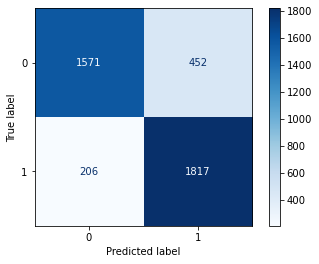

In [58]:
#plot confusion_matrix
plot_confusion_matrix(lr, Xsm_val, ysm_val, cmap = 'Blues');

In [59]:
confusion_matrix_eval(ysm_val, lr.predict(Xsm_val))


True Positives   : 1817
True Negative    : 1571
False Positives  : 452
False Negative   : 206

Accuracy           = 83.74%
Misclassification  = 16.26%
Precision          = 80.08%
Sensitivity        = 89.82%
Specificity        = 77.66%


In [60]:
# generate file for Kaggle
pred = get_proba(lr, X_test)
submit_df(pred, 'lr_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### Random Forest Classifier

In [61]:
rf  = classifier_model(RandomForestClassifier(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 RandomForestClassifier() 

Train Accuracy Rate           = 1.0
Unseen Train Accuracy Rate    = 0.9624
Validation Accuracy Rate      = 0.8238
ROC score on Testing dataset  = 0.824


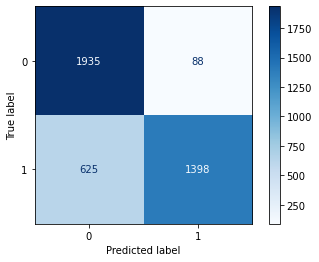

In [62]:
#plot confusion_matrix
plot_confusion_matrix(rf, Xsm_val, ysm_val, cmap = 'Blues');

In [63]:
confusion_matrix_eval(ysm_val, rf.predict(Xsm_val))


True Positives   : 1398
True Negative    : 1935
False Positives  : 88
False Negative   : 625

Accuracy           = 82.38%
Misclassification  = 17.62%
Precision          = 94.08%
Sensitivity        = 69.11%
Specificity        = 95.65%


In [64]:
# generate file for Kaggle
pred = get_proba(rf, X_test)
submit_df(pred, 'rf_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### KNeighbors Classifier

In [65]:
kn = classifier_model(KNeighborsClassifier(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 KNeighborsClassifier() 

Train Accuracy Rate           = 0.9555
Unseen Train Accuracy Rate    = 0.9338
Validation Accuracy Rate      = 0.7519
ROC score on Testing dataset  = 0.752


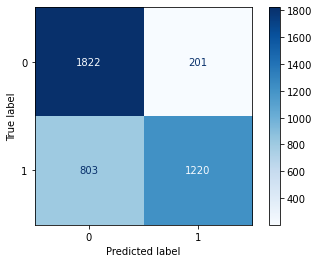

In [66]:
#plot confusion_matrix
plot_confusion_matrix(kn, Xsm_val, ysm_val, cmap = 'Blues');

In [67]:
confusion_matrix_eval(ysm_val, kn.predict(Xsm_val))


True Positives   : 1220
True Negative    : 1822
False Positives  : 201
False Negative   : 803

Accuracy           = 75.19%
Misclassification  = 24.81%
Precision          = 85.86%
Sensitivity        = 60.31%
Specificity        = 90.06%


In [68]:
# generate file for Kaggle
pred = get_proba(kn, X_test)
submit_df(pred, 'kn_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### Adaboost

In [69]:
ada = classifier_model(AdaBoostClassifier(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 AdaBoostClassifier() 

Train Accuracy Rate           = 0.8904
Unseen Train Accuracy Rate    = 0.886
Validation Accuracy Rate      = 0.8875
ROC score on Testing dataset  = 0.888


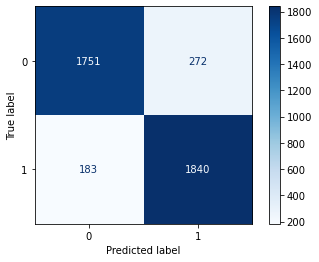

In [70]:
#plot confusion_matrix

plot_confusion_matrix(ada, Xsm_val, ysm_val, cmap = 'Blues');

In [71]:
confusion_matrix_eval(ysm_val, ada.predict(Xsm_val))


True Positives   : 1840
True Negative    : 1751
False Positives  : 272
False Negative   : 183

Accuracy           = 88.75%
Misclassification  = 11.25%
Precision          = 87.12%
Sensitivity        = 90.95%
Specificity        = 86.55%


In [72]:
# generate file for Kaggle
pred = get_proba(ada, X_test)
submit_df(pred, 'ada_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### BernoulliNB

In [73]:
nb = classifier_model(BernoulliNB(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 BernoulliNB() 

Train Accuracy Rate           = 0.7151
Unseen Train Accuracy Rate    = 0.7122
Validation Accuracy Rate      = 0.7054
ROC score on Testing dataset  = 0.705


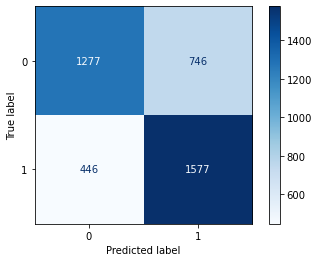

In [74]:
#plot confusion_matrix

plot_confusion_matrix(nb, Xsm_val, ysm_val, cmap = 'Blues');

In [75]:
confusion_matrix_eval(ysm_val, nb.predict(Xsm_val))


True Positives   : 1577
True Negative    : 1277
False Positives  : 746
False Negative   : 446

Accuracy           = 70.54%
Misclassification  = 29.46%
Precision          = 67.89%
Sensitivity        = 77.95%
Specificity        = 63.12%


In [76]:
# generate file for Kaggle
pred = get_proba(ada, X_test)
submit_df(pred, 'nb_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


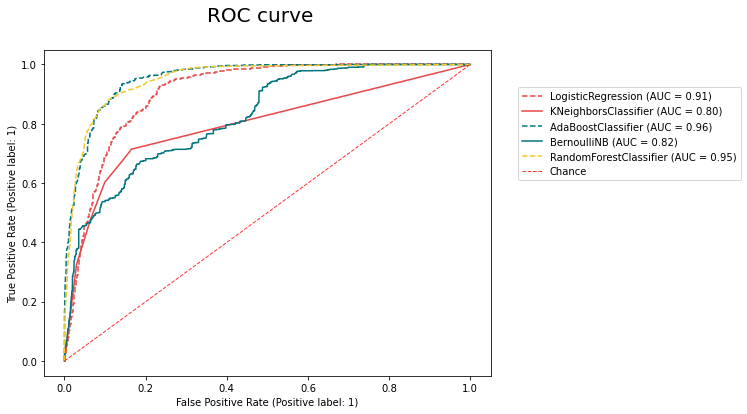

In [77]:
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('ROC curve',fontsize=20)

plot_roc_curve(lr,Xsm_val,ysm_val, ax=ax, name='LogisticRegression', linestyle='--',color='#e84545')
plot_roc_curve(kn,Xsm_val,ysm_val, ax=ax, name='KNeighborsClassifier',color='#e84545')
plot_roc_curve(ada,Xsm_val,ysm_val, ax=ax, name='AdaBoostClassifier', linestyle='--',color='#007580')
plot_roc_curve(nb,Xsm_val,ysm_val, ax=ax, name='BernoulliNB',color='#007580')
plot_roc_curve(rf,Xsm_val,ysm_val, ax=ax, name='RandomForestClassifier', linestyle='--',color='#f0c929')

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

plt.legend(bbox_to_anchor=(1.05, 0.9));

# 4 Evaluate Model (1st round)

Adaboost has the lowest False Negative but the kaggle score is low when compare with LR

# 5 Time Series Feature Engineering

- **Lagging of the time** - as we now the mosquitoes need time to hatch 2 weeks or Mosquitoes will lay eggs in puddles. Puddle such as this that remain days after rainfall occurring are appealing locations for mosquitoes. Therefore lagging of time will help us see the trend of WNV

In [78]:
weather.head(3)

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,...,avgspeed,day,month,year,week,hour_sunrise,min_sunrise,hour_sunset,min_sunset,r_humidity
0,2007-05-01,83.5,51.0,67.5,14.0,51.0,56.5,0.0,2.5,448.0,...,9.40,1.0,5.0,2007.0,18.0,4.0,48.0,18.0,49.0,55.485
1,2007-05-02,59.5,42.5,51.5,-3.0,42.0,47.0,13.5,0.0,447.0,...,13.40,2.0,5.0,2007.0,18.0,4.0,47.0,18.0,50.0,69.905
2,2007-05-03,66.5,47.0,57.0,2.0,40.0,49.0,8.0,0.0,446.0,...,12.55,3.0,5.0,2007.0,18.0,4.0,46.0,18.0,51.0,52.965


### adding Lag features in weather dataframe

In [79]:
# list of features for time lag 
var = ['tavg', 'dewpoint', 'snowfall','preciptotal', 'sealevel', 'resultdir', 'avgspeed', 'r_humidity']

lag_features = weather[var]

In [80]:
# set the number of lags in days
lags = (1,3,7,14,17,21,24,27)

final_weather = weather.assign(**{f'{col}_lag_{n}': 
                                       lag_features[col].shift(n) for n in lags for col in lag_features})

In [81]:
#check shape
final_weather.shape

(1472, 92)

In [82]:
#drop null row from lag_features
final_weather = final_weather.dropna()

In [83]:
#check shape
final_weather.shape

(1445, 92)

In [84]:
#merge train and new weather date
final_df = pd.merge(train, final_weather.drop(columns = ['day','month','year']), on = 'date', how = 'left')
#final_df.to_csv('final_df_v2.csv')

### Drop strong co-correlate feature

- We drop tmax / tmin becuase using only tavg to decrease redundant data
- We drop wetbulb because have a strong correlate with dewpoint (to decrease number of feature). 
- We drop stnpressure because have a strong correlate with sealevel (to decrease number of feature).
- We drop resultspeed because have a strong correlate with averagespeed (to decrease number of feature).

In [85]:
#merge train and new weather date
final_df.drop(columns = ['date','addressaccuracy','tmax','tmin','wetbulb','stnpressure','resultspeed','trap'], inplace = True)

In [86]:
final_df.head(3)

,species,latitude,longitude,nummosquitos,wnvpresent,day,month,year,week_x,tavg,...,avgspeed_lag_24,r_humidity_lag_24,tavg_lag_27,dewpoint_lag_27,snowfall_lag_27,preciptotal_lag_27,sealevel_lag_27,resultdir_lag_27,avgspeed_lag_27,r_humidity_lag_27
0,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,29,5,2007,22,75.5,...,11.75,44.845,51.5,42.0,0.0,0.0,30.085,3.0,13.4,69.905
1,CULEX RESTUANS,41.954690,-87.800991,1,0,29,5,2007,22,75.5,...,11.75,44.845,51.5,42.0,0.0,0.0,30.085,3.0,13.4,69.905
2,CULEX RESTUANS,41.994991,-87.769279,1,0,29,5,2007,22,75.5,...,11.75,44.845,51.5,42.0,0.0,0.0,30.085,3.0,13.4,69.905


In [87]:
#merge test and new weather date
final_test = pd.merge(test, final_weather.drop(columns = ['day','month','year']), on = 'date', how = 'left')

In [88]:
final_test.drop(columns = ['date','addressaccuracy','tmax','tmin','wetbulb','stnpressure','resultspeed','trap'], inplace = True)

In [89]:
#check cols
set(final_df.columns) - set(final_test.columns)

{'wnvpresent'}

### Get dummy for Category Cols

**Train File**

In [90]:
#get all category cols
cat_col = list(final_df.select_dtypes(['object']).columns)

In [91]:
final_df = pd.get_dummies(data = final_df, columns = cat_col, drop_first = True)

In [92]:
#check shaoe
final_df.shape

(8461, 94)

**Test File**

In [93]:
#
final_test = pd.get_dummies(data = final_test, columns = cat_col, drop_first = True)

In [94]:
#check shaoe
final_test.shape

(116293, 94)

# 6 Feature Selection

<AxesSubplot:>

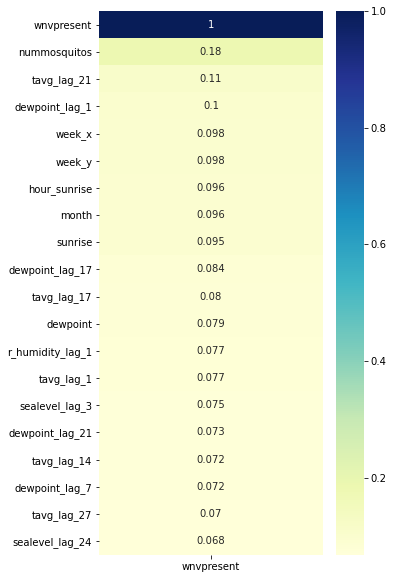

In [95]:
# show top 20 features high corr with target
plt.figure(figsize = (5,10))
sns.heatmap(final_df.corr()[['wnvpresent']].sort_values(by = 'wnvpresent',ascending = False)[:20], annot = True,cmap="YlGnBu")

In [96]:
# function to get the high corr cols in list
def get_top_high_corr_features_lst(df,target):
    criteria = 0.05
    corr_col_lst_tmp = df.corr()[target]
    print(corr_col_lst_tmp[( np.abs(corr_col_lst_tmp) >= criteria ) ].sort_values(ascending = False))
    top_high_corr_features_lst_tmp = corr_col_lst_tmp[( np.abs(corr_col_lst_tmp) >= criteria ) ].index.values.tolist()
    return top_high_corr_features_lst_tmp

In [97]:
features = get_top_high_corr_features_lst(final_df,'wnvpresent')
features.remove('wnvpresent')
print('\n\ntotal number of high corr features =',len(features))


wnvpresent                1.000000
nummosquitos              0.183891
tavg_lag_21               0.114531
dewpoint_lag_1            0.103555
week_x                    0.097836
week_y                    0.097836
hour_sunrise              0.096488
month                     0.096264
sunrise                   0.094979
dewpoint_lag_17           0.084468
tavg_lag_17               0.080005
dewpoint                  0.079169
r_humidity_lag_1          0.077241
tavg_lag_1                0.077093
sealevel_lag_3            0.075144
dewpoint_lag_21           0.072677
tavg_lag_14               0.072413
dewpoint_lag_7            0.071782
tavg_lag_27               0.069591
sealevel_lag_24           0.067952
r_humidity_lag_3          0.067946
dewpoint_lag_24           0.063611
dewpoint_lag_27           0.063162
tavg_lag_24               0.062894
tavg                      0.060201
preciptotal_lag_1         0.056148
tavg_lag_7                0.055999
dewpoint_lag_14           0.055564
cool                

Assign target variable and features

In [98]:
X = final_df[features]
y = final_df['wnvpresent']

### Split data to X,y Train and Val

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify =y)

In [100]:
#X_val_org = X_val
#y_val_org = y_val
#X_val_org.shape

### Scale data by using StandardScaler

In [101]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_val_sc = ss.transform(X_val)

### Balance Target variable by using SMOTE

In [102]:
sm = SMOTE()

Xsm_train, ysm_train = sm.fit_resample(X_train_sc, y_train)
Xsm_val, ysm_val = sm.fit_resample(X_val_sc, y_val)

In [103]:
#Xsm_val.shape

In [104]:
# Instantiate PCA with 10 components.
#from sklearn.decomposition import PCA
#pca = PCA(n_components = 20)

# Fit PCA to training data.
#pca.fit(Xsm_train)
#Xsm_train = pca.transform(Xsm_train)
#Xsm_val = pca.transform(Xsm_val)

**Test Data**

In [105]:
X_test = final_test[features]
X_test = ss.transform(X_test)

In [106]:
#X_test = pca.transform(X_test)

# 7 Modeling ( 2st round )

### Logistic Regression

In [107]:
lr = classifier_model(LogisticRegression(), Xsm_train, Xsm_val, ysm_train, ysm_val)


#pca = PCA(n_components = 30)

# Fit PCA to training data.
#pca.fit(Xsm_train)
#Xsm_train = pca.transform(Xsm_train)
#Xsm_val = pca.transform(Xsm_val)
#lr = classifier_model(LogisticRegression(C=1.0, penalty='l2'), Xsm_train, Xsm_val, ysm_train, ysm_val)

#lr = classifier_model(LogisticRegression(C=1.0, class_weight='balanced', penalty='l1', solver='liblinear'), Xsm_train, Xsm_val, ysm_train, ysm_val)


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 



 LogisticRegression() 

Train Accuracy Rate           = 0.8147
Unseen Train Accuracy Rate    = 0.8126
Validation Accuracy Rate      = 0.8445
ROC score on Testing dataset  = 0.845


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


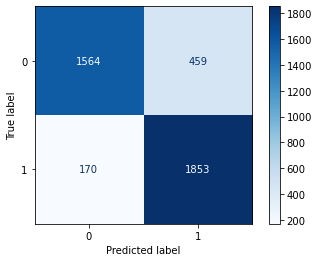

In [108]:
#plot confusion_matrix
plot_confusion_matrix(lr, Xsm_val, ysm_val, cmap = 'Blues');

In [109]:
confusion_matrix_eval(ysm_val, lr.predict(Xsm_val))


True Positives   : 1853
True Negative    : 1564
False Positives  : 459
False Negative   : 170

Accuracy           = 84.45%
Misclassification  = 15.55%
Precision          = 80.15%
Sensitivity        = 91.60%
Specificity        = 77.31%


In [110]:
# generate file for Kaggle
#X_test = pca.transform(X_test)
pred = get_proba(lr, X_test)
submit_df(pred, 'lr_timelag_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


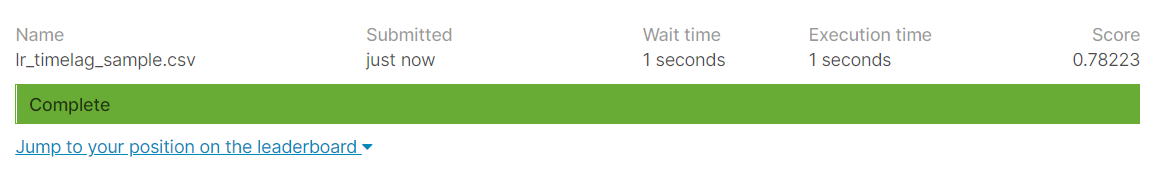

In [111]:
len(lr.coef_)

1

<AxesSubplot:>

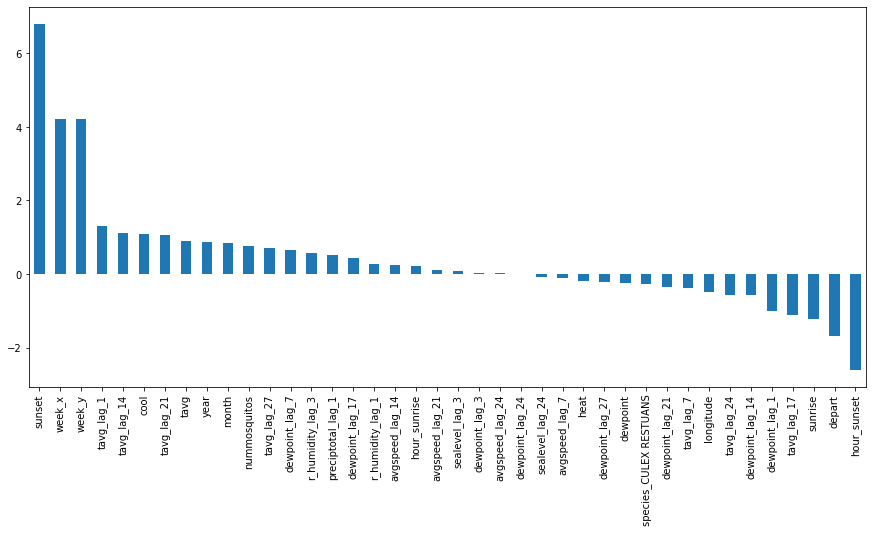

In [112]:
# show the coef in each feature, see some features can be removed from the predictor list
pd.Series(lr.coef_[0], index=features).sort_values(ascending=False).plot.bar(figsize=(15, 7))

In [113]:
top_features = pd.Series(lr.coef_[0], index=features).sort_values(ascending=False)[:15]
top_features

sunset               6.801769
week_x               4.226871
week_y               4.226871
tavg_lag_1           1.297969
tavg_lag_14          1.109044
cool                 1.080221
tavg_lag_21          1.060312
tavg                 0.889415
year                 0.871572
month                0.856441
nummosquitos         0.755076
tavg_lag_27          0.699394
dewpoint_lag_7       0.650115
r_humidity_lag_3     0.565690
preciptotal_lag_1    0.524267
dtype: float64

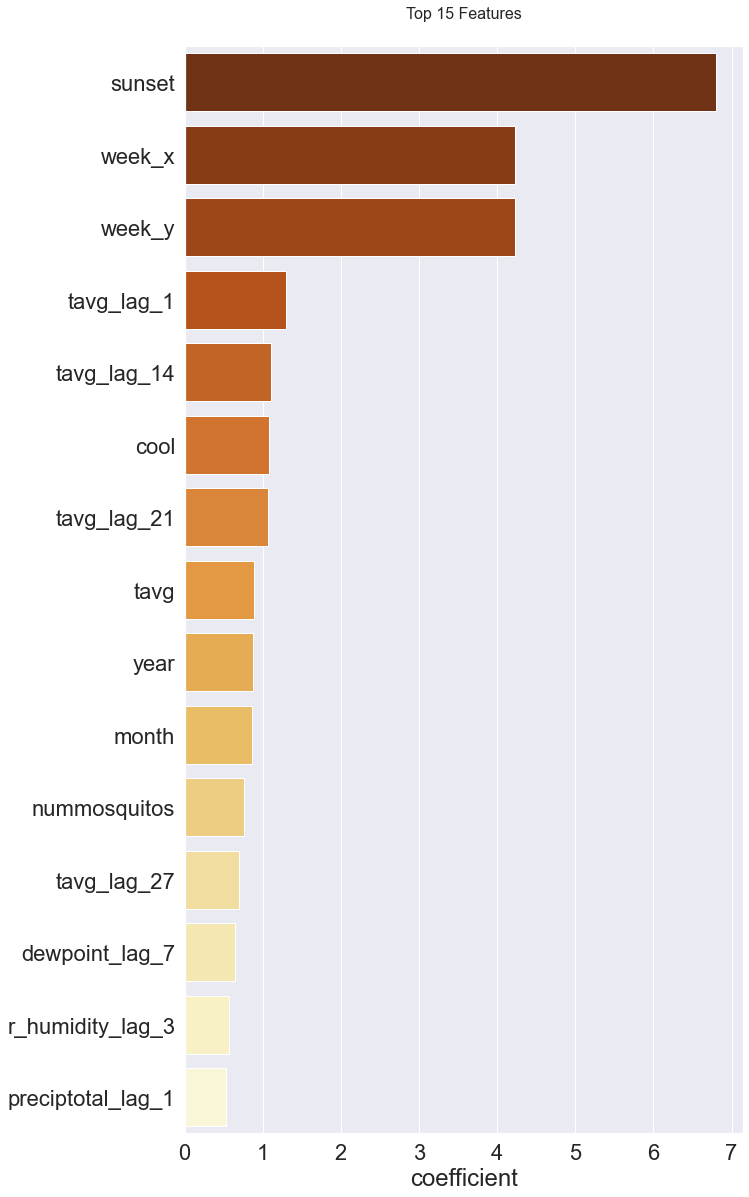

In [114]:

sns.set(font_scale=2)
plt.figure(figsize = (10,20))
g = sns.barplot(x=top_features,
            y=list(top_features.index),
           palette='YlOrBr_r')
g.set_title('Top 15 Features',y=1.02,fontsize=16)
g.set_xlabel('coefficient');


### Random Forest Classifier

In [115]:
rf = classifier_model(RandomForestClassifier(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 RandomForestClassifier() 

Train Accuracy Rate           = 0.9996
Unseen Train Accuracy Rate    = 0.9445
Validation Accuracy Rate      = 0.8117
ROC score on Testing dataset  = 0.812


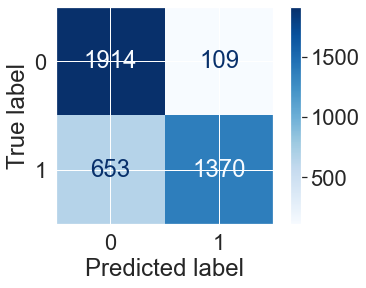

In [116]:
#plot confusion_matrix
plot_confusion_matrix(rf, Xsm_val, ysm_val, cmap = 'Blues');

In [117]:
confusion_matrix_eval(ysm_val, rf.predict(Xsm_val))


True Positives   : 1370
True Negative    : 1914
False Positives  : 109
False Negative   : 653

Accuracy           = 81.17%
Misclassification  = 18.83%
Precision          = 92.63%
Sensitivity        = 67.72%
Specificity        = 94.61%


In [118]:
# generate file for Kaggle
pred = get_proba(rf, X_test)
submit_df(pred, 'rf_timelag_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### KNeighbors Classifier

In [119]:
kn = classifier_model(KNeighborsClassifier(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 KNeighborsClassifier() 

Train Accuracy Rate           = 0.9479
Unseen Train Accuracy Rate    = 0.9236
Validation Accuracy Rate      = 0.7674
ROC score on Testing dataset  = 0.767


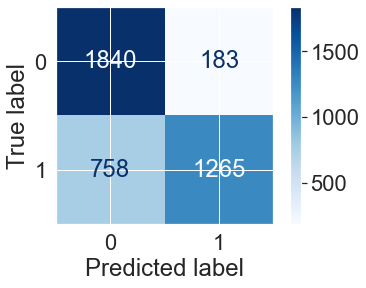

In [120]:
#plot confusion_matrix
plot_confusion_matrix(kn, Xsm_val, ysm_val, cmap = 'Blues');

In [121]:
confusion_matrix_eval(ysm_val, kn.predict(Xsm_val))


True Positives   : 1265
True Negative    : 1840
False Positives  : 183
False Negative   : 758

Accuracy           = 76.74%
Misclassification  = 23.26%
Precision          = 87.36%
Sensitivity        = 62.53%
Specificity        = 90.95%


In [122]:
# generate file for Kaggle
pred = get_proba(kn, X_test)
submit_df(pred, 'kn_timelag_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### Adaboost

In [123]:
ada =classifier_model(AdaBoostClassifier(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 AdaBoostClassifier() 

Train Accuracy Rate           = 0.8946
Unseen Train Accuracy Rate    = 0.8913
Validation Accuracy Rate      = 0.8888
ROC score on Testing dataset  = 0.889


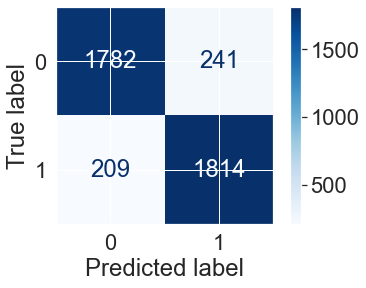

In [124]:
#plot confusion_matrix
plot_confusion_matrix(ada, Xsm_val, ysm_val, cmap = 'Blues');

In [125]:
confusion_matrix_eval(ysm_val, ada.predict(Xsm_val))


True Positives   : 1814
True Negative    : 1782
False Positives  : 241
False Negative   : 209

Accuracy           = 88.88%
Misclassification  = 11.12%
Precision          = 88.27%
Sensitivity        = 89.67%
Specificity        = 88.09%


In [126]:
# generate file for Kaggle
pred = get_proba(ada, X_test)
submit_df(pred, 'ada_timelag_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


### BernoulliNB

In [127]:
nb =classifier_model(BernoulliNB(), Xsm_train, Xsm_val, ysm_train, ysm_val)



 BernoulliNB() 

Train Accuracy Rate           = 0.7367
Unseen Train Accuracy Rate    = 0.736
Validation Accuracy Rate      = 0.7546
ROC score on Testing dataset  = 0.755


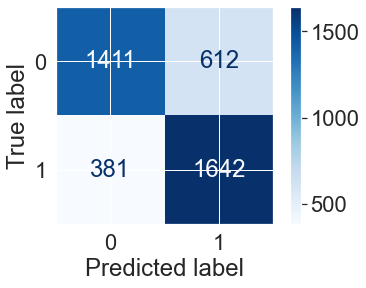

In [128]:
#plot confusion_matrix
plot_confusion_matrix(nb, Xsm_val, ysm_val, cmap = 'Blues');

In [129]:
confusion_matrix_eval(ysm_val, nb.predict(Xsm_val))


True Positives   : 1642
True Negative    : 1411
False Positives  : 612
False Negative   : 381

Accuracy           = 75.46%
Misclassification  = 24.54%
Precision          = 72.85%
Sensitivity        = 81.17%
Specificity        = 69.75%


In [130]:
# generate file for Kaggle
pred = get_proba(nb, X_test)
submit_df(pred, 'nb_timelag_sample')

<ipython-input-56-580ab2aafe86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['WnvPresent'] = pred


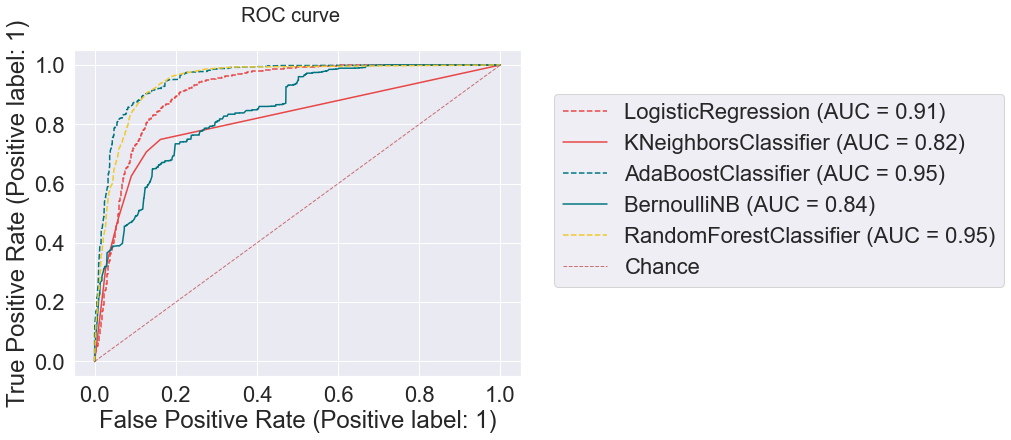

In [131]:
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('ROC curve',fontsize=20)

plot_roc_curve(lr,Xsm_val,ysm_val, ax=ax, name='LogisticRegression', linestyle='--',color='#e84545')
plot_roc_curve(kn,Xsm_val,ysm_val, ax=ax, name='KNeighborsClassifier',color='#e84545')
plot_roc_curve(ada,Xsm_val,ysm_val, ax=ax, name='AdaBoostClassifier', linestyle='--',color='#007580')
plot_roc_curve(nb,Xsm_val,ysm_val, ax=ax, name='BernoulliNB',color='#007580')
plot_roc_curve(rf,Xsm_val,ysm_val, ax=ax, name='RandomForestClassifier', linestyle='--',color='#f0c929')

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

plt.legend(bbox_to_anchor=(1.05, 0.9));

# 8 Evaluate Model (2nd round)

LR has the lowest False Negative and the kaggle score is the best when compare with others

---